
## Supernova Classification Project

Supernovae are powerful stellar explosions that provide critical insights into astrophysics and cosmology.  
Type Ia supernovae, in particular, act as **standard candles**, allowing us to measure cosmic distances and study the expansion of the Universe.  


## Overview

**Notebook Author:** `Topollo Naketsana` <br>

**Github Repo:** [project](https://github.com/topollonaketsana/)

#### Python packages used in this project

* pandas
* seaborn
* matplotlib
* astropy
* numpy
* scipy 


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sncosmo
from astropy.table import Table
from sklearn.svm import SVC

### 1. Feature Extraction

In this stage, the goal is to extract meaningful features from the raw supernova light-curve data.  
Each light curve (a set of flux measurements over time and filter) is modeled using the **SALT2** model, which describes the brightness evolution of Type Ia supernovae.

By fitting this model to the observed data, we obtain a compact set of parameters:

- **z** — redshift of the supernova  
- **t₀** — time of peak brightness  
- **x₀** — amplitude (related to overall brightness)  
- **x₁** — stretch parameter (describes how broad or narrow the light curve is)  
- **c** — color parameter (captures color and extinction effects)

These parameters serve as **features** that summarize the essential behavior of each supernova.  
They transform complex, irregular time-series data into a standardized numerical representation suitable for further analysis — such as classification, regression, or cosmological studies.

This stage performs **feature extraction through model fitting**, reducing high-dimensional observational data into a low-dimensional, physically interpretable form.

In [3]:
# 1. Define the fitting function

def fit_supernova(lc):
    
    """
    Small function to fit a light curve with the SALT2 model, using sncosmo and iminuit.
    
    Parameters
    -----------
    lc : astropy.table.Table
        Light curve (in the format sncosmo expects)
    
    Returns
    ----------
    z, t0, x0, x1, c
        Best-fitting parameters of the model
    """

    bnds = {'z':(0.01, 1.5), 't0':(-100,100),
            'x0':(-1e-3, 1e-3), 'x1':(-3, 3), 'c':(-0.5, 0.5)}
    mod = sncosmo.Model('salt2-extended')
    res = sncosmo.fit_lc(lc, mod, vparam_names=mod.param_names,
                         bounds=bnds, minsnr=0)
    return res[0].parameters


In [4]:
# 2. Loop through light curves and extract features
import glob

# Saving extracted data
lightcurve_files = glob.glob("../data/supernovae_data/supernovae_data/*.dat")
results = []

'''for i, file in enumerate(lightcurve_files):
    lc = Table.read(file, format='ascii')

    try:
        params = fit_supernova(lc)
        results.append({
                'id': i,
                'z': params[0],
                't0': params[1],
                'x0': params[2],
                'x1': params[3],
                'c': params[4]
    })

    except Exception as e:
        print(f"Skipping {file}: {e}")

    continue


# Convert results to DataFrame
data = pd.DataFrame(results)

# Save as CSV
data.to_csv('../data/extracted_features.csv', index= False)
print('Feature extraction completed and saved to extracted_features.csv')'''

'for i, file in enumerate(lightcurve_files):\n    lc = Table.read(file, format=\'ascii\')\n\n    try:\n        params = fit_supernova(lc)\n        results.append({\n                \'id\': i,\n                \'z\': params[0],\n                \'t0\': params[1],\n                \'x0\': params[2],\n                \'x1\': params[3],\n                \'c\': params[4]\n    })\n\n    except Exception as e:\n        print(f"Skipping {file}: {e}")\n\n    continue\n\n\n# Convert results to DataFrame\ndata = pd.DataFrame(results)\n\n# Save as CSV\ndata.to_csv(\'../data/extracted_features.csv\', index= False)\nprint(\'Feature extraction completed and saved to extracted_features.csv\')'

#### 2. Loading and upacking the data

In [5]:
# open the extracted data file
df = pd.read_csv('../data/extracted_features.csv')

# open the data - first 5 entries
df.head()

,id,z,t0,x0,x1,c
0,0,0.601080,65.205601,0.000003,2.999999,-0.088068
1,1,0.785841,-22.479036,0.000008,-1.790085,-0.499999
2,2,0.678913,25.382915,0.000013,3.000000,0.155391
3,3,0.543420,66.681840,0.000003,0.309919,0.354393
4,4,0.662057,56.742185,0.000002,-2.447243,0.454916


### 3. Preprocessing


Before training the model, we can first study the dataset by checking the `info`, `describe`, etc. We also check if the dataset contains any missing values

In [6]:
# dimensions
df.shape

(2000, 6)

In [7]:
# infomation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2000 non-null   int64  
 1   z       2000 non-null   float64
 2   t0      2000 non-null   float64
 3   x0      2000 non-null   float64
 4   x1      2000 non-null   float64
 5   c       2000 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 93.9 KB


In [8]:
df.describe()

,id,z,t0,x0,x1,c
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,0.698871,48.175616,0.000005,0.985767,0.008360
std,577.494589,0.128744,28.874087,0.000017,2.141008,0.220614
min,0.000000,0.047369,-99.924991,-0.000013,-3.000000,-0.500000
25%,499.750000,0.661561,32.247203,0.000002,-0.983573,-0.137041
50%,999.500000,0.695215,57.140290,0.000003,1.602654,0.003188
75%,1499.250000,0.754246,66.939980,0.000005,3.000000,0.150305
max,1999.000000,1.456614,100.000000,0.000419,3.000000,0.500000


In [9]:
# since data is all numerical, we can check the mean fro nan
df.isna().mean()

id    0.0
z     0.0
t0    0.0
x0    0.0
x1    0.0
c     0.0
dtype: float64

#### Data contains no missing values and it is in numerical type `dtype` - `float64`

### 4. Visualization 

#### 4.1 Pre - fitting exploration

We study the data before it was extracted - to expore the brightness variation (Light curve)

In [10]:
import os

data_root = '../data/supernovae_data/supernovae_data'
lc_file = os.path.join(data_root, '34.dat')
lc = Table.read(lc_file, format='ascii')

In [11]:
# from table to csv
lc_df = lc.to_pandas()

lc_df.head()

,mjd,filter,flux,flux_error,zp,zpsys
0,0.000,desg,95.18,5.147,27.5,ab
1,0.008,desr,116.10,3.062,27.5,ab
2,0.024,desi,102.80,3.700,27.5,ab
3,0.047,desz,103.70,3.153,27.5,ab
4,2.997,desg,174.70,4.272,27.5,ab


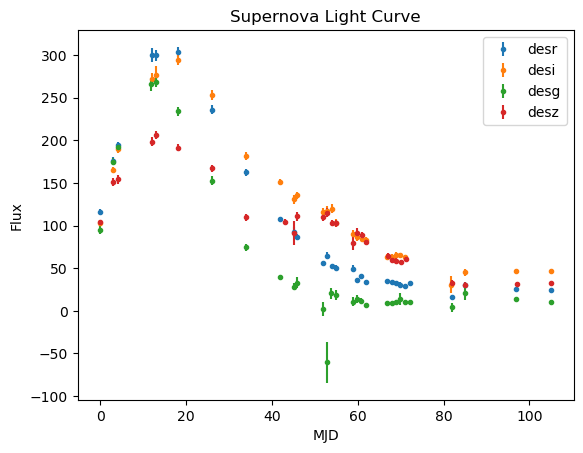

In [12]:
# plot - flux varying with time (Light curve)
for band in set(lc_df['filter']):
    band_data = lc_df[lc_df['filter'] == band]
    plt.errorbar(band_data['mjd'], band_data['flux'],
                 yerr= band_data['flux_error'], fmt='.', label= band)

plt.xlabel('MJD')
plt.ylabel('Flux')
plt.title('Supernova Light Curve')
plt.legend()

plt.show()

#### 4.2 Post-Fitting exploration

c:\Users\topol\anaconda3\Lib\site-packages\sncosmo\fitting.py:191: RuntimeWarning: Dropping following bands from data: desg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


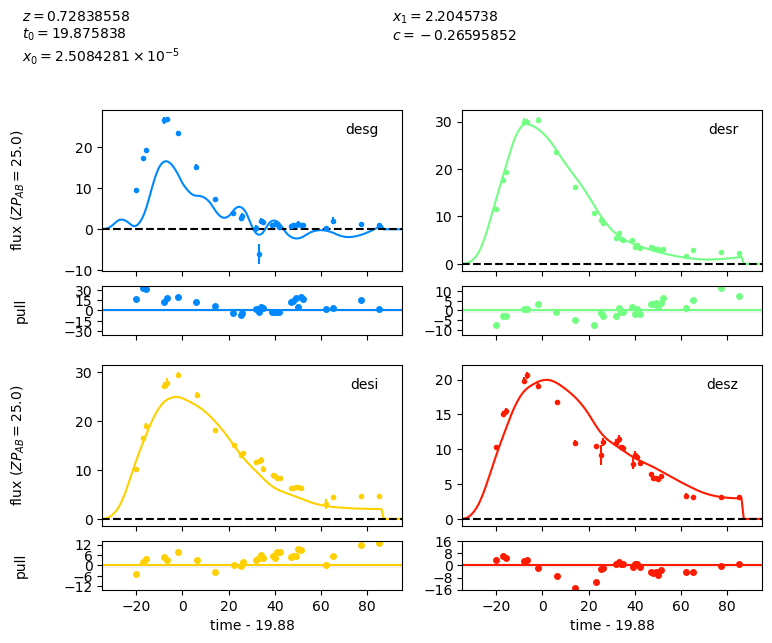

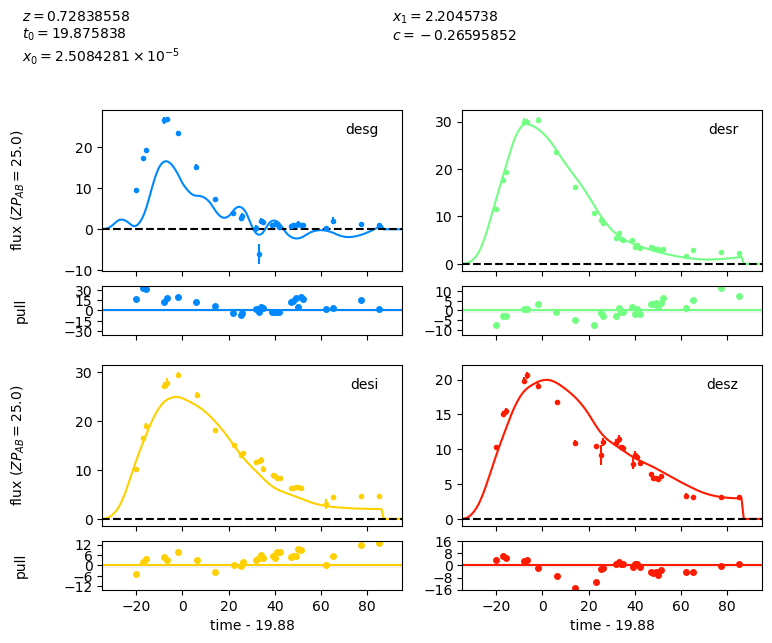

In [13]:
# model and fitting
prms = fit_supernova(lc)
mod = sncosmo.Model('salt2-extended')
mod.parameters = prms

# light curve with sncosmo
sncosmo.plot_lc(lc, mod)

####

### 5. Split data


To run the ML algorithm - Classification, we need to split the dataset into Train set and Test set.We use the ML scikit-learn packages to split the data called `train_test_split`

In [14]:
# target and features 
target = np.loadtxt('../data/labels.txt')
y = target[:, 1]
X = df

# from scikit learn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state= 42)

In [15]:
print(f'The shape of X train set {X_train.shape}')
print(f'The shape of the y train set {y_train.shape}')

The shape of X train set (1800, 6)
The shape of the y train set (1800,)


### 6. Scale the features